# AE646 Indivisual Project
### Arush Raju Chinchkhede | 220212

All the sources for cross validating my results are obtained form the research paper 

# Gortler Transformation

Gortler transformation is related to flow on curved surface. Unlike flow over a wedge, Gortler Transformation allows us to have an analytic solution for flow over curved surface. The main difference between the wedge flow and curved surface flow is the free stream condition.
Free stream condition for flow over a wedge is of the form $U(x) = U*x^m $ where m depend on wedge parameter.
But Gortler transformation is valid for any kind of flow with known free stream condition like $U(x) = u_0 + u_1x + u_2x^2 .... $ which makes it have an advantage.

## Governing equation and Boundary conditions
Since the problem is steady, no initial conditions requried.

![my image](Governing_equation_and_boundary_equation.png)

Give below is the diagram of my domain for training my model.

![Description of Image](About_domain_of_training_model.png)


In gortler Transformation there are two cases 

a) For flow with stagnation point at $x = 0$ and $U(x) = u_1x + u_2x^2 + u_3x^3 + ....$

b) And for flow wih no stagnation point $U(x) = u_0 + u_1x + u_2x^2 + u_3x^3 + ....$

Choosen here the case with no forward stagnation point of the free stream and $U(x) = 1$. This is essentially **Blausious Solution** but with gortler's transformation.

## Hyperparameter for the Neural Network
Input: $\eta$ and $\xi$

Output: $F(\eta,\xi)$

Number of doamin points : 5000

Number of boundary points: 2000

Hidden layers : 50

Learning rate : 1e-5

Epochs: 1e+4

Activation function: 'relu'

Using backend: tensorflow.compat.v1
Other supported backends: tensorflow, pytorch, jax, paddle.
paddle supports more examples now and is recommended.



Instructions for updating:
non-resource variables are not supported in the long term
Compiling model...
Building feed-forward neural network...
'build' took 0.220675 s


'compile' took 2.978105 s

Training model...

Step      Train loss                                  Test loss                                   Test metric
0         [0.00e+00, 1.81e-01, 4.02e-03, 1.03e+00]    [0.00e+00, 1.81e-01, 4.02e-03, 1.03e+00]    []  
10        [0.00e+00, 1.64e-01, 3.94e-03, 1.04e+00]    [0.00e+00, 1.64e-01, 3.94e-03, 1.04e+00]    []  
20        [0.00e+00, 1.48e-01, 3.85e-03, 1.04e+00]    [0.00e+00, 1.48e-01, 3.85e-03, 1.04e+00]    []  
30        [0.00e+00, 1.33e-01, 3.77e-03, 1.04e+00]    [0.00e+00, 1.33e-01, 3.77e-03, 1.04e+00]    []  
40        [0.00e+00, 1.20e-01, 3.71e-03, 1.04e+00]    [0.00e+00, 1.20e-01, 3.71e-03, 1.04e+00]    []  
50        [0.00e+00, 1.08e-01, 3.65e-03, 1.04e+00]    [0.00e+00, 1.08e-01, 3.65e-03, 1.04e+00]    []  
60        [0.00e+00, 9.68e-02, 3.62e-03, 1.04e+00]    [

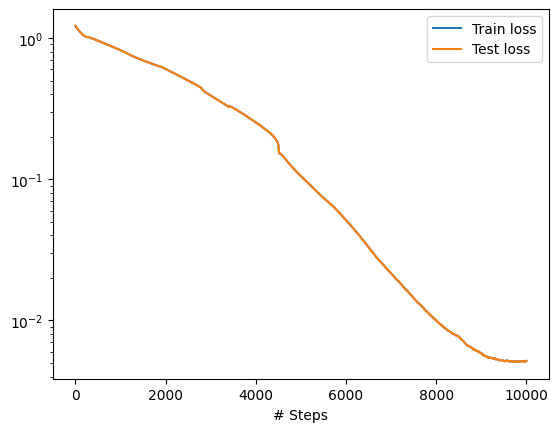

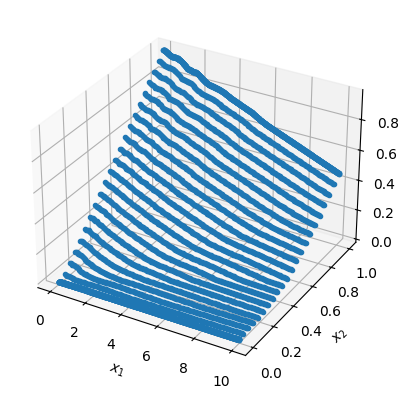

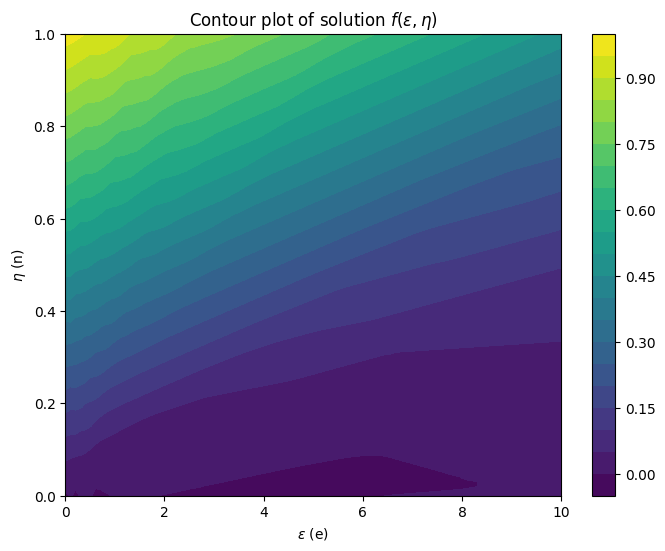

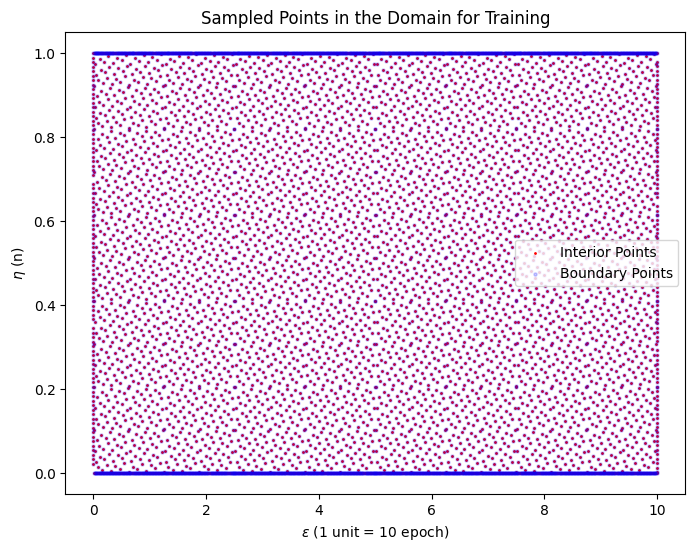

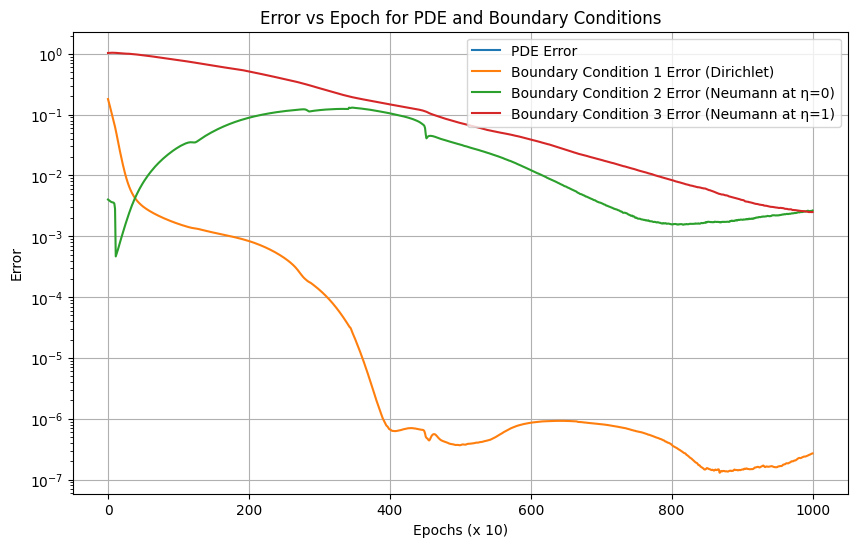

In [1]:
# Importing the functions
import deepxde as dde
import numpy as np
import matplotlib.pyplot as plt

v = 0.01 # defining the viscoity
u = 1 # defining the free stream velocity over the flat plat

def pde(x, y):
    e = x[:, 0:1]  # epsilon (x component)
    n = x[:, 1:2]  # eta (y component)
    f = y[:, 0:1]
    f_e = dde.grad.jacobian(y, x, i=0, j=0)
    f_n = dde.grad.jacobian(y, x, i=0, j=1)
    f_ee = dde.grad.hessian(y, x, component=0, i=0, j=0)
    f_nn = dde.grad.hessian(y, x, component=0, i=0, j=1)
    f_nnn = dde.grad.jacobian(f_nn, x, i=0, j=1)
    f_ne = dde.grad.jacobian(f_n, x, i=0, j=1)
    beta = 0 # Falt plate problem
    
    eq = f_nnn + f*f_nn + beta*(1 + f_n**2) - 2*e*(f_n*f_ne - f_e*f_nn)
    return [eq]

# Boundary conditions
def bc1(x, on_boundary):
    return on_boundary and np.isclose(x[1], 1.0)

def bc2(x, on_boundary):
    return on_boundary and np.isclose(x[1], 0.0)

def f_n_equals_one(x):
    return np.ones_like(x[:, 0:1])

def f_n_equals_zero(x):
    return np.zeros_like(x[:, 0:1])

def f_equal_to_zero(x):
    return np.zeros_like(x[:, 0:1])

geom = dde.geometry.Rectangle([0, 0], [10, 1])

f_surface_boundary = dde.icbc.boundary_conditions.DirichletBC(geom, f_equal_to_zero, bc2, component=0)
f_n_surface_boundary = dde.icbc.boundary_conditions.NeumannBC(geom, f_n_equals_zero, bc2, component=0)
f_n_far_boundary = dde.icbc.boundary_conditions.NeumannBC(geom, f_n_equals_one, bc1, component=0)

# Data for the problem
data = dde.data.PDE(
    geom,
    pde,
    [f_surface_boundary, f_n_surface_boundary, f_n_far_boundary],
    num_domain=5000,
    num_boundary=2000,
    num_test=4000,
)

# Model definition
layer_size = [2] + [50] * 3 + [1]
activation = "relu"
initializer = "Glorot uniform"
net = dde.nn.FNN(layer_size, activation, initializer)

model = dde.Model(data, net)
model.compile("adam", lr=0.00001)

# Train the model
losshistory, train_state = model.train(epochs = 10000 ,display_every = 10,disregard_previous_best=True)

# Save the training plot (as per your current code)
dde.saveplot(losshistory, train_state, issave=True, isplot=True)

# Generate a structured grid of points for e (epsilon) and n (eta)
# We create a meshgrid to cover the domain (e from 0 to 10, n from 0 to 1)
e_values = np.linspace(0, 10, 100)  # epsilon (0 to 10)
n_values = np.linspace(0, 1, 100)   # eta (0 to 1)
E, N = np.meshgrid(e_values, n_values)  # Create a grid of (e, n) values

# Reshape for DeepXDE input
grid_points = np.vstack([E.flatten(), N.flatten()]).T  # Reshape to 2D array for input

# Evaluate the trained model at these grid points
f_values = model.predict(grid_points)[:, 0]  # Get the solution f

# Reshape f_values to match the grid shape (E, N) for contour plotting
F = f_values.reshape(E.shape)

# Create the contour plot
plt.figure(figsize=(8, 6))
cp = plt.contourf(E, N, F, 20, cmap='viridis')  # 20 contour levels
plt.colorbar(cp)  # Add color bar to indicate solution values
plt.xlabel(r"$\epsilon$ (e)")
plt.ylabel(r"$\eta$ (n)")
plt.title(r"Contour plot of solution $f(\epsilon, \eta)$")

plt.savefig("FinalContour (f vs eta,xi).png", format="png", dpi=600)
plt.show()
# Extract training points (interior and boundary points)
X_domain = data.train_points()            # Interior points
X_boundary = data.train_points(boundary=True)  # Boundary points

# Scatter plot for interior and boundary points
plt.figure(figsize=(8, 6))
plt.scatter(X_domain[:, 0], X_domain[:, 1], s=1, color='red', alpha=1, label='Interior Points')    # Interior points
plt.scatter(X_boundary[:, 0], X_boundary[:, 1], s=5, color='blue',alpha=0.2, label='Boundary Points')  # Boundary points

# Labeling the plot
plt.xlabel(r"$\epsilon$ (1 unit = 10 epoch)")
plt.ylabel(r"$\eta$ (n)")
plt.title("Sampled Points in the Domain for Training")
plt.legend()

plt.savefig("FinalDomain.png", format="png", dpi=600)
plt.show()

# Extracting the loss history for each component
loss_data = np.array(losshistory.loss_train)  # Converting to numpy array for easy indexing

# Plotting the error for each component
plt.figure(figsize=(10, 6))
epochs = np.arange(len(loss_data))  # Create an array of epoch numbers

# Assuming the order is: [PDE error, BC1 error, BC2 error, BC3 error]
plt.plot(epochs, loss_data[:, 0], label="PDE Error")
plt.plot(epochs, loss_data[:, 1], label="Boundary Condition 1 Error (Dirichlet)")
plt.plot(epochs, loss_data[:, 2], label="Boundary Condition 2 Error (Neumann at η=0)")
plt.plot(epochs, loss_data[:, 3], label="Boundary Condition 3 Error (Neumann at η=1)")

# Labeling the plot
plt.xlabel("Epochs (x 10)")
plt.ylabel("Error")
plt.yscale("log")  # Log scale can help if errors vary significantly
plt.title("Error vs Epoch for PDE and Boundary Conditions")
plt.legend()
plt.grid(True)
plt.savefig(r"Final_Error_vs_Epoch.jpg", format="jpeg", dpi=600)
plt.show()

Now that we are done with training our model, its time to test it. The domain of my problem is a rectangle of lenght $(10 * 1)$ with $x$ going from 0 to 10 and $y$ from 0 to 1. And at each point $(x,y)$, there corresponding $(\eta,\xi)$ is calculated and is sent into the neutral network to get the output $f(\eta,\xi)$ and the results are plotted.

The values of $\xi$ and $\eta$ is calculated by the following formulas of paper, that relates then with $(x,y)$

![My Image](Eta_and_Epsilon_form_x_and_y.png)

Since the neural network is trained for similarity variables $\eta$ and $\xi$ in $(0,1)$ and  $(0,10)$ the values of $x$ and $y$ I have selected is such that with the above relation, it does result in $\eta$ and $\xi$ in $(0,1)$ and  $(0,10)$

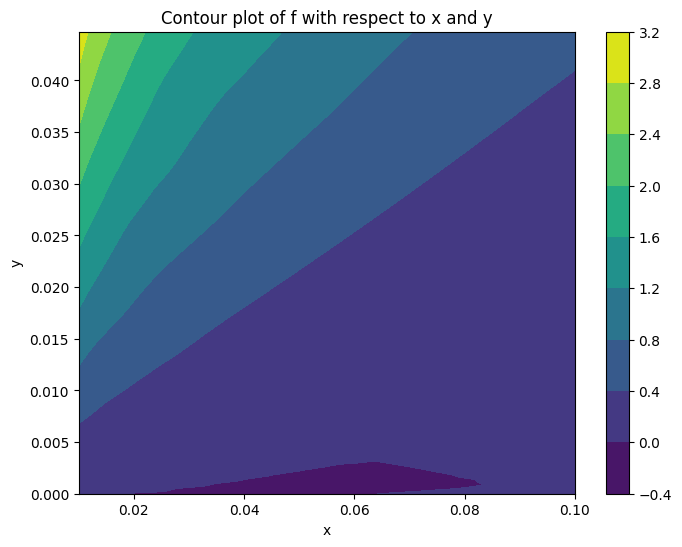

In [4]:
v = 0.01
# Define the range of x and y values
x_range = np.linspace(0.01, 0.1, 100)  # x between 0.01 and 0.1
y_range = np.linspace(0, 0.04472, 100)   # y between 0 and 0.04472

# Generate a grid of (x, y) points
x_grid, y_grid = np.meshgrid(x_range, y_range)

# Flatten the grid for input into the model
grid_points = np.vstack([x_grid.flatten(), y_grid.flatten()]).T

# Apply the transformations to get eta and epsilon

# To calculate eta values
def eta_values(x, y):
    eta = (y)/(2*v*x)**0.5
    return eta

# To calculate epsilon values
def epsilon_values(x, y):
    epsilon = (1/v)*x
    return epsilon

# Apply eta and epsilon calculations for each grid point (vectorized)
eta_vals = eta_values(grid_points[:, 0], grid_points[:, 1])
epsilon_vals = epsilon_values(grid_points[:, 0], grid_points[:, 1])

# Prepare the input for the model in the format [eta, epsilon]
inputs = np.vstack([epsilon_vals,eta_vals]).T

# Use the trained model to predict f at the given points
f_values = model.predict(inputs)

# Reshape the predicted f values to match the grid shape
f_grid = f_values.reshape(x_grid.shape)

# Plot the contour of f with respect to x and y
plt.figure(figsize=(8, 6))
cp = plt.contourf(x_grid, y_grid, f_grid, cmap='viridis')
plt.colorbar(cp)  # Show the colorbar for reference
plt.title('Contour plot of f with respect to x and y')
plt.xlabel('x')
plt.ylabel('y')
plt.savefig(r"(1) Contour of f wrt x and y.jpg", format="jpeg", dpi=600)
plt.show()

$F$ as mentioned in the slides is directly proportional to the streamlines of the problem. Shown here the contour of $F$ with $\eta$ and $\xi$. And each line with fixed color will represent the function $F = C$, where C is some constant. Essencially, $\psi(\eta,\xi)$ = constant

# For the case of flow over perpendicular Flat plate

Compiling model...
Building feed-forward neural network...
'build' took 0.135459 s

'compile' took 1.247257 s

Training model...

Step      Train loss                                  Test loss                                   Test metric
0         [9.78e-01, 3.27e-01, 5.20e-03, 1.05e+00]    [9.79e-01, 3.27e-01, 5.20e-03, 1.05e+00]    []  
10        [9.82e-01, 2.89e-01, 5.57e-03, 1.04e+00]    [9.82e-01, 2.89e-01, 5.57e-03, 1.04e+00]    []  
20        [9.85e-01, 2.54e-01, 5.96e-03, 1.03e+00]    [9.86e-01, 2.54e-01, 5.96e-03, 1.03e+00]    []  
30        [9.89e-01, 2.22e-01, 6.38e-03, 1.02e+00]    [9.90e-01, 2.22e-01, 6.38e-03, 1.02e+00]    []  
40        [9.92e-01, 1.94e-01, 6.82e-03, 1.01e+00]    [9.93e-01, 1.94e-01, 6.82e-03, 1.01e+00]    []  
50        [9.96e-01, 1.68e-01, 7.29e-03, 1.01e+00]    [9.97e-01, 1.68e-01, 7.29e-03, 1.01e+00]    []  
60        [1.00e+00, 1.46e-01, 7.79e-03, 9.96e-01]    [1.00e+00, 1.46e-01, 7.79e-03, 9.96e-01]    []  
70        [1.00e+00, 1.26e-01, 8.31e-03

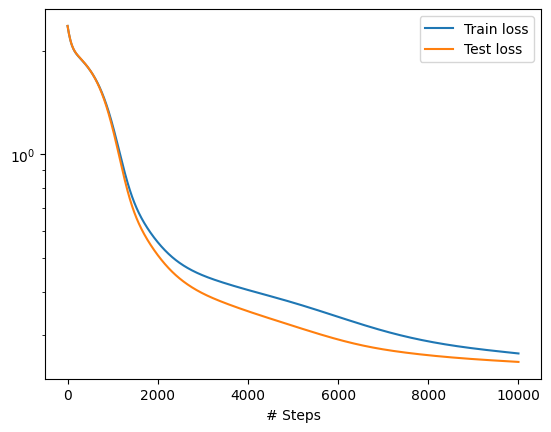

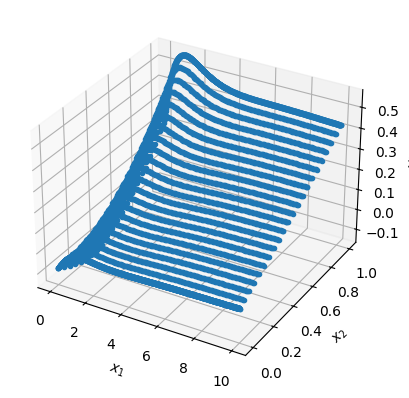

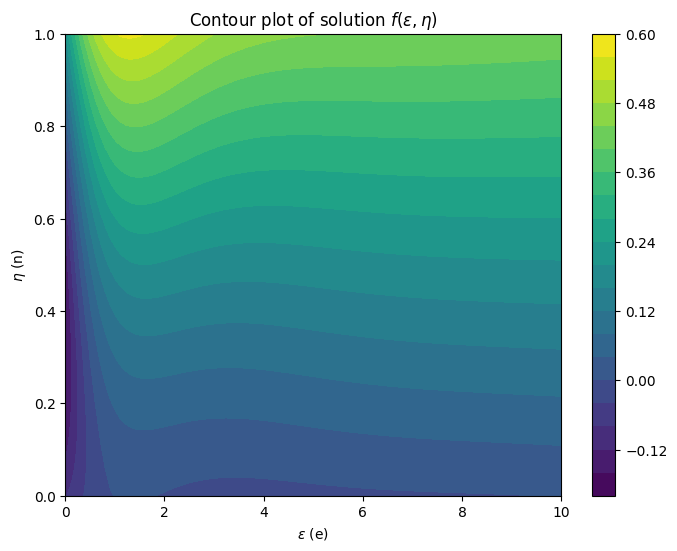

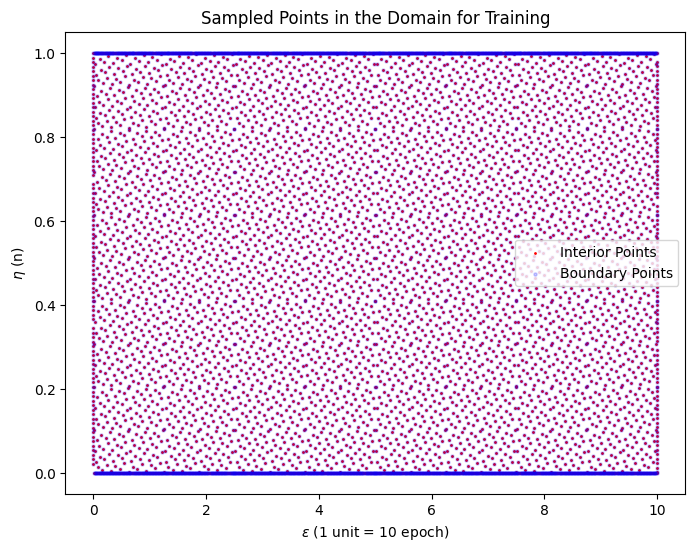

NameError: name 'losshistory' is not defined

In [2]:
import deepxde as dde
import numpy as np
import matplotlib.pyplot as plt

v = 0.01 # defining the viscoity
u = 1 # defining the free stream velocity over the flat plat

def pde_90(x, y):
    e = x[:, 0:1]  # epsilon (x component)
    n = x[:, 1:2]  # eta (y component)
    f = y[:, 0:1]
    f_e = dde.grad.jacobian(y, x, i=0, j=0)
    f_n = dde.grad.jacobian(y, x, i=0, j=1)
    f_ee = dde.grad.hessian(y, x, component=0, i=0, j=0)
    f_nn = dde.grad.hessian(y, x, component=0, i=0, j=1)
    f_nnn = dde.grad.jacobian(f_nn, x, i=0, j=1)
    f_ne = dde.grad.jacobian(f_n, x, i=0, j=1)
    beta = 1 # Perpendicular plate problem
    
    eq = f_nnn + f*f_nn + beta*(1 + f_n**2) - 2*e*(f_n*f_ne - f_e*f_nn)
    return [eq]

# Boundary conditions
def bc1_90(x, on_boundary):
    return on_boundary and np.isclose(x[1], 1.0)

def bc2_90(x, on_boundary):
    return on_boundary and np.isclose(x[1], 0.0)

def f_n_equals_one_90(x):
    return np.ones_like(x[:, 0:1])

def f_n_equals_zero_90(x):
    return np.zeros_like(x[:, 0:1])

def f_equal_to_zero_90(x):
    return np.zeros_like(x[:, 0:1])

geom_90 = dde.geometry.Rectangle([0, 0], [10, 1])

f_surface_boundary_90 = dde.icbc.boundary_conditions.DirichletBC(geom_90, f_equal_to_zero_90, bc2_90, component=0)
f_n_surface_boundary_90 = dde.icbc.boundary_conditions.NeumannBC(geom_90, f_n_equals_zero_90, bc2_90, component=0)
f_n_far_boundary_90 = dde.icbc.boundary_conditions.NeumannBC(geom_90, f_n_equals_one_90, bc1_90, component=0)

# Data for the problem
data_90 = dde.data.PDE(
    geom_90,
    pde_90,
    [f_surface_boundary_90, f_n_surface_boundary_90, f_n_far_boundary_90],
    num_domain=5000,
    num_boundary=2000,
    num_test=4000,
)

# Model definition
layer_size_90 = [2] + [50] * 3 + [1]
activation_90 = "tanh"
initializer_90 = "Glorot uniform"
net_90 = dde.nn.FNN(layer_size_90, activation_90, initializer_90)

model_90 = dde.Model(data_90, net_90)
model_90.compile("adam", lr=0.00001)

# Train the model
losshistory_90, train_state_90 = model_90.train(epochs = 10000 ,display_every = 10,disregard_previous_best=True)

# Save the training plot (as per your current code)
dde.saveplot(losshistory_90, train_state_90, issave=True, isplot=True)


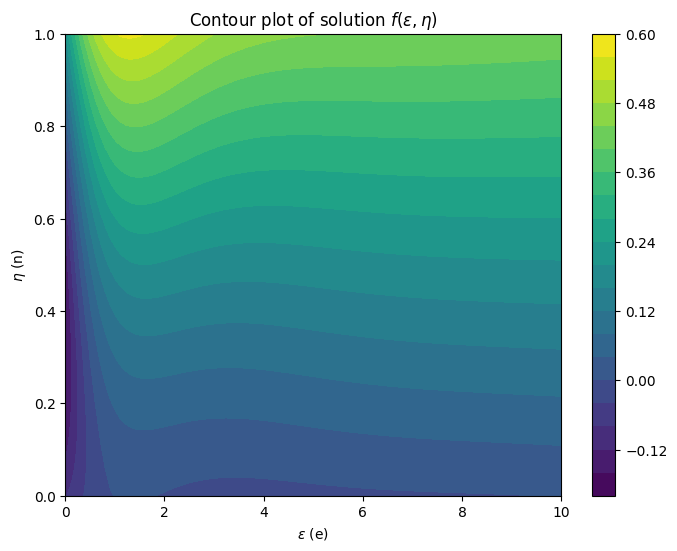

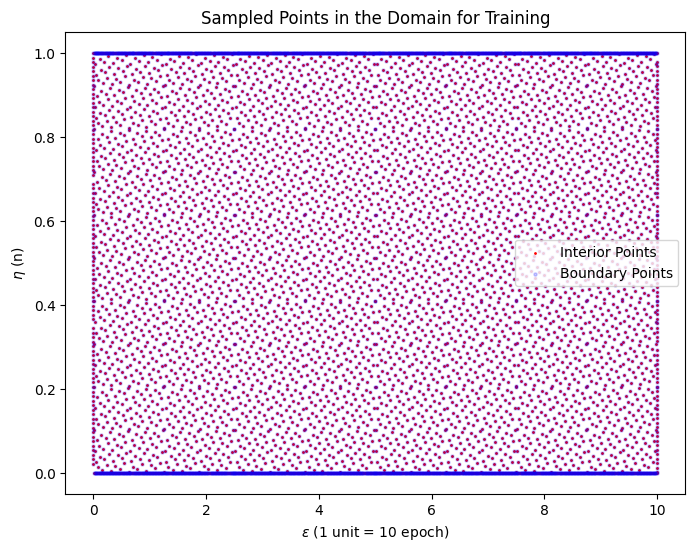

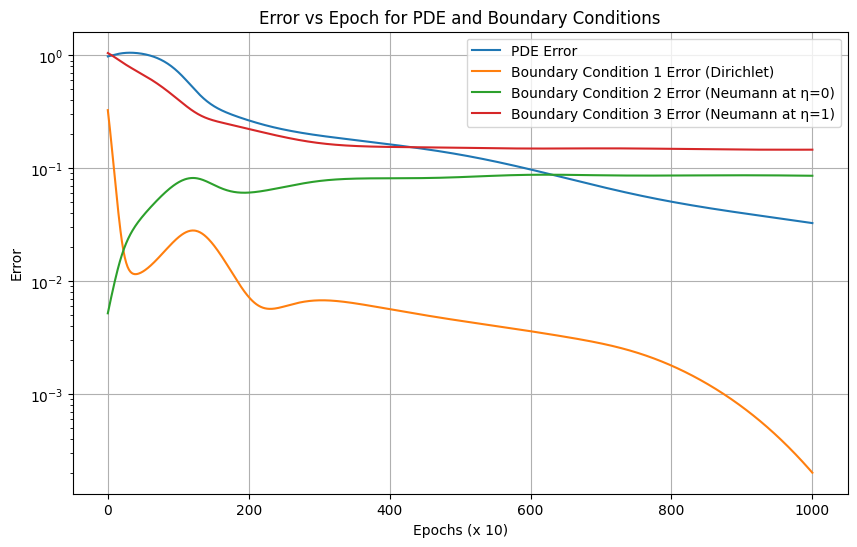

In [4]:
# Generate a structured grid of points for e (epsilon) and n (eta)
# We create a meshgrid to cover the domain (e from 0 to 10, n from 0 to 1)
e_values_90 = np.linspace(0, 10, 100)  # epsilon (0 to 10)
n_values_90 = np.linspace(0, 1, 100)   # eta (0 to 1)
E_90, N_90 = np.meshgrid(e_values_90, n_values_90)  # Create a grid of (e, n) values

# Reshape for DeepXDE input
grid_points_90 = np.vstack([E_90.flatten(), N_90.flatten()]).T  # Reshape to 2D array for input

# Evaluate the trained model at these grid points
f_values_90 = model_90.predict(grid_points_90)[:, 0]  # Get the solution f

# Reshape f_values to match the grid shape (E, N) for contour plotting
F_90 = f_values_90.reshape(E_90.shape)

# Create the contour plot
plt.figure(figsize=(8, 6))
cp_90 = plt.contourf(E_90, N_90, F_90, 20, cmap='viridis')  # 20 contour levels
plt.colorbar(cp_90)  # Add color bar to indicate solution values
plt.xlabel(r"$\epsilon$ (e)")
plt.ylabel(r"$\eta$ (n)")
plt.title(r"Contour plot of solution $f(\epsilon, \eta)$")

plt.savefig("FinalContour (f vs eta,xi).png", format="png", dpi=600)
plt.show()
# Extract training points (interior and boundary points)
X_domain_90 = data_90.train_points()            # Interior points
X_boundary_90 = data_90.train_points(boundary=True)  # Boundary points

# Scatter plot for interior and boundary points
plt.figure(figsize=(8, 6))
plt.scatter(X_domain_90[:, 0], X_domain_90[:, 1], s=1, color='red', alpha=1, label='Interior Points')    # Interior points
plt.scatter(X_boundary_90[:, 0], X_boundary_90[:, 1], s=5, color='blue',alpha=0.2, label='Boundary Points')  # Boundary points

# Labeling the plot
plt.xlabel(r"$\epsilon$ (1 unit = 10 epoch)")
plt.ylabel(r"$\eta$ (n)")
plt.title("Sampled Points in the Domain for Training")
plt.legend()

plt.savefig("FinalDomain.png", format="png", dpi=600)
plt.show()

# Extracting the loss history for each component
loss_data_90 = np.array(losshistory_90.loss_train)  # Converting to numpy array for easy indexing

# Plotting the error for each component
plt.figure(figsize=(10, 6))
epochs_90 = np.arange(len(loss_data_90))  # Create an array of epoch numbers

# Assuming the order is: [PDE error, BC1 error, BC2 error, BC3 error]
plt.plot(epochs_90, loss_data_90[:, 0], label="PDE Error")
plt.plot(epochs_90, loss_data_90[:, 1], label="Boundary Condition 1 Error (Dirichlet)")
plt.plot(epochs_90, loss_data_90[:, 2], label="Boundary Condition 2 Error (Neumann at η=0)")
plt.plot(epochs_90, loss_data_90[:, 3], label="Boundary Condition 3 Error (Neumann at η=1)")

# Labeling the plot
plt.xlabel("Epochs (x 10)")
plt.ylabel("Error")
plt.yscale("log")  # Log scale can help if errors vary significantly
plt.title("Error vs Epoch for PDE and Boundary Conditions")
plt.legend()
plt.grid(True)
plt.savefig(r"Final_Error_vs_Epoch.jpg", format="jpeg", dpi=600)
plt.show()

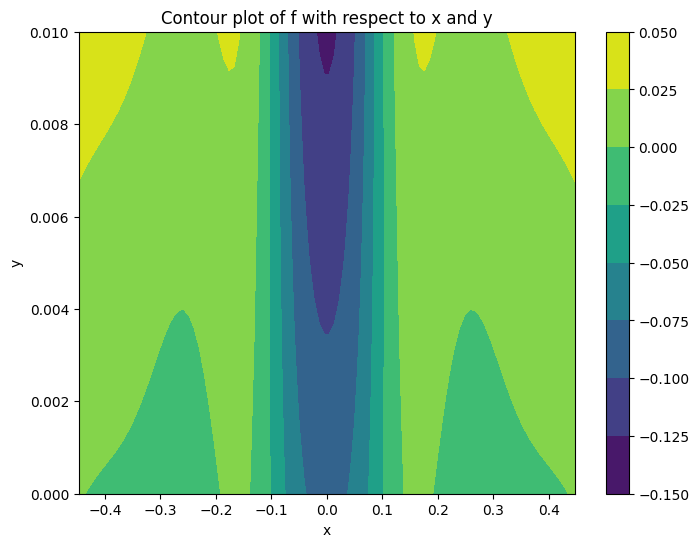

In [7]:
v = 0.01
# Define the range of x and y values
x_range_90 = np.linspace(-0.44721, 0.44721, 100)  # x between 0.01 and 0.1
y_range_90 = np.linspace(0, 0.01, 100)   # y between 0 and 0.04472

# Generate a grid of (x, y) points
x_grid_90, y_grid_90 = np.meshgrid(x_range_90, y_range_90)

# Flatten the grid for input into the model
grid_points_90 = np.vstack([x_grid_90.flatten(), y_grid_90.flatten()]).T

# Apply the transformations to get eta and epsilon

# To calculate eta values
def eta_values_90(x, y):
    eta = (y)/((v)**0.5)
    return eta

# To calculate epsilon values
def epsilon_values_90(x, y):
    epsilon = (1/v)*((x**2)/2)
    return epsilon

# Apply eta and epsilon calculations for each grid point (vectorized)
eta_vals_90 = eta_values_90(grid_points_90[:, 0], grid_points_90[:, 1])
epsilon_vals_90 = epsilon_values_90(grid_points_90[:, 0], grid_points_90[:, 1])

# Prepare the input for the model in the format [eta, epsilon]
inputs_90 = np.vstack([epsilon_vals_90,eta_vals_90]).T

# Use the trained model to predict f at the given points
f_values_90 = model_90.predict(inputs_90)

# Reshape the predicted f values to match the grid shape
f_grid_90 = f_values_90.reshape(x_grid_90.shape)

# Plot the contour of f with respect to x and y
plt.figure(figsize=(8, 6))
cp_90 = plt.contourf(x_grid_90, y_grid_90, f_grid_90, cmap='viridis')
plt.colorbar(cp_90)  # Show the colorbar for reference
plt.title('Contour plot of f with respect to x and y')
plt.xlabel('x')
plt.ylabel('y')
plt.savefig(r"(2) Contour of f wrt x and y.jpg", format="jpeg", dpi=600)
plt.show()

Here as well the value of $F$ will do represent the streamlines, but for 90 degree flat plate 